In [1]:
import numpy as np
import pathlib
import pyvisa
import time
import matplotlib.pyplot as plt
import math
from datetime import datetime
TODAY_STR = datetime.now().strftime("%Y%m%d")
print(f"\x1b[1;3;4;96mDate of running the code:\x1b[0m \x1b[1;3;4;92m{TODAY_STR}\x1b[0m")

Date of running the code: 20241101


In [2]:
CHIP_ID = f"Freespace-{TODAY_STR}"
FEATURE_ID = "new_GRIN_Groove_with_YSO_crystal_0.005E_-10DbMr"

PM_RANGE = 10

# FEATURE_ID = 'col2_row_ring_top_weirdcoupling'
print(f"{CHIP_ID} {FEATURE_ID} {PM_RANGE}")

Freespace-20241016 new_GRIN_Groove_with_YSO_crystal_0.005E_-10DbMr 10


In [3]:
grating_file_name = pathlib.Path(f"{CHIP_ID}_{FEATURE_ID}.npz")
if grating_file_name.is_file():
    print("Found existing file. Plotting...")
    grating_input_data = np.load(grating_file_name)
    data_arr_cut = grating_input_data["data_arr_cut"]
    wav_arr = grating_input_data["wav_arr"]
    del grating_input_data
    plt.close()
    plt.plot(wav_arr, data_arr_cut)
    plt.grid()
    plt.xlabel("wavelength (nm)")
    plt.ylabel("voltage (V)")
    plt.title(f"{CHIP_ID}_{FEATURE_ID} transmission")
    plt.annotate(
        f"Power meter range: {PM_RANGE} dBm",
        (0.15, 0.75),
        xycoords="axes fraction",
        alpha=0.6,
        fontsize=12,
        fontfamily="monospace",
    )
    plt.show()
else:
    print("\x1b[0;93mNo existing file found. Proceeding...\x1b[0m")

No existing file found. Proceeding...


In [2]:
rm = pyvisa.ResourceManager()
rm.list_resources()

('TCPIP::169.254.112.67::INSTR',
 'TCPIP::169.254.112.67::INSTR',
 'TCPIP::169.254.112.67::INSTR',
 'TCPIP::169.254.112.67::INSTR')

In [5]:
is_connect_success = False 
while not is_connect_success:
    try:
        DSO = rm.open_resource("TCPIP0::169.254.82.2::inst0::INSTR")
        print(DSO.query("*IDN?"))
        print("\x1b[0;92mDSO Connection established.\x1b[0m")
        is_connect_success = True
    except pyvisa.VisaIOError:
        print("Retrying...")
        time.sleep(0.5)

Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...
Retrying...


KeyboardInterrupt: 

In [3]:
is_connect_success = False 
while not is_connect_success:
    try:
        TSL = rm.open_resource("TCPIP::169.254.82.30::5000::SOCKET", read_termination="\r")
        print(TSL.query("*IDN?"))
        print("\x1b[0;92mTSL Connection established.\x1b[0m")
        is_connect_success = True
    except pyvisa.VisaIOError:
        print("Retrying...")
        time.sleep(0.5)

if TSL.query(":POW:STAT?") == "+0":
    TSL.write(":POW:STAT 1")
    time.sleep(0.5)
    print("Laser was off. Turning on laser.")

Exception: could not connect: -1073807339

In [7]:
def getData(DSO, channel=2):
    DSO.write(f":WAV:SOUR CHAN{int(channel)}")
    DSO.write(":WAV:POINTS 5500000")
    sRange = DSO.query("WAV:PRE?")
    lRange = sRange.split(",")
    # <format 16-bit NR1>, <type 16-bit NR1>, <points 32-bit NR1>, <count 32-bit NR1>,
    # <xincrement 64-bit floating point NR3>, <xorigin 64-bit floating point NR3>,
    # <xreference 32-bit NR1>,
    # <yincrement 32-bit floating point NR3>, <yorigin 32-bit floating point NR3>,
    # <yreference 32-bit NR1>
    # iStep = 256 if int(lRange[0])==0 else 65536
    # pts = int(lRange[2])
    dt = float(lRange[4])
    gain = float(lRange[7])
    y_offs = float(lRange[8])
    y_offs_byte = int(lRange[9])
    # get data as i16, convert to numpy array
    DSO.write("WAV:DATA?")
    sHead0 = DSO.read_bytes(count=10)
    # strip header to find # of points
    i0 = sHead0.find(b"#")
    nDig = int(chr(sHead0[i0 + 1]))  # [i0+1:i0+2])
    nByte = int((sHead0[i0 + 2 : i0 + 2 + nDig]))
    # read data, including final line feed
    sData = DSO.read_bytes(count=1 + nByte)
    # get data to numpy array
    vData = np.frombuffer(sData[:-1], dtype="uint8")
    data_arr = gain * (vData) + y_offs - gain * (y_offs_byte)
    time_arr = np.linspace(0, data_arr.size, data_arr.size) * dt
    # time.sleep(5)

    return data_arr, time_arr

In [7]:
TSL.query("TRIG:OUTP:STEP?")

'+1.00000000E-011'

In [8]:
WAV_START = 1480
WAV_END = 1640

In [9]:
TSL.write("WAV:SWE 0")
time.sleep(0.5)
TSL.write(F"WAV:SWE:STAR {WAV_START}E-9")
time.sleep(0.1)
TSL.write(F"WAV:SWE:STOP {WAV_END}E-9")
time.sleep(0.1)
TSL.write("WAV:SWE 1")
time.sleep(0.1)

In [11]:
time_range = 10
time_pos = 4
DSO.write(f":TIM:RANG {time_range}")
time.sleep(0.1)
DSO.write(f":TIM:POS {time_pos}")
time.sleep(0.1)
DSO.write("SING")
time.sleep(0.1)

In [12]:
time.sleep(2)
TSL.write(":TRIG:INP:SOFT")
time.sleep(time_range*1.1)

In [13]:
data_arr, time_arr = getData(DSO, channel=1)
time.sleep(0.1)
clock_arr, time_arr = getData(DSO, channel=2)
time.sleep(0.1)

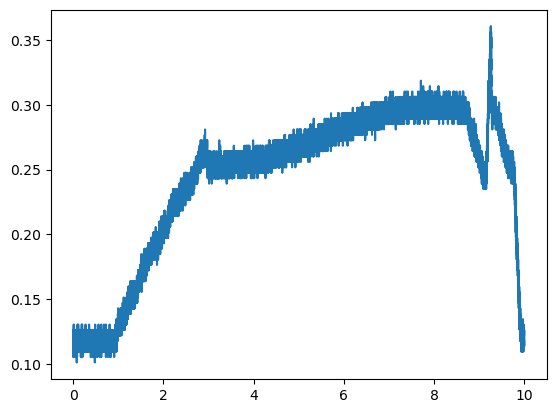

In [14]:
plt.plot(time_arr, data_arr)
plt.show()

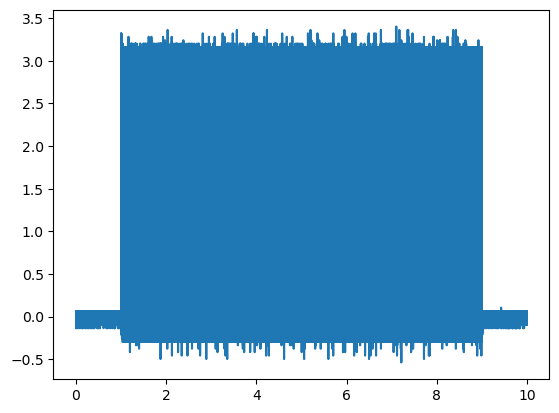

In [15]:
plt.plot(time_arr, clock_arr)
plt.show()

In [16]:
# start_idx = np.where(clock_arr>4)[0][0]
# end_idx = np.where(clock_arr>4)[0][-1]
start_idx = np.where(clock_arr > 0.5)[0][0]
end_idx = np.where(clock_arr > 0.5)[0][-1]

In [17]:
time_arr_cut = time_arr[start_idx:end_idx]
data_arr_cut = data_arr[start_idx:end_idx]
clock_arr_cut = clock_arr[start_idx:end_idx]

In [18]:
# wav_arr = np.linspace(1600, 1500, time_arr_cut.size)
# wav_arr = np.linspace(1500, 1600, time_arr_cut.size)
wav_arr = np.linspace(WAV_START, WAV_END, time_arr_cut.size)

In [19]:
chip_name = f"{CHIP_ID} {FEATURE_ID}"

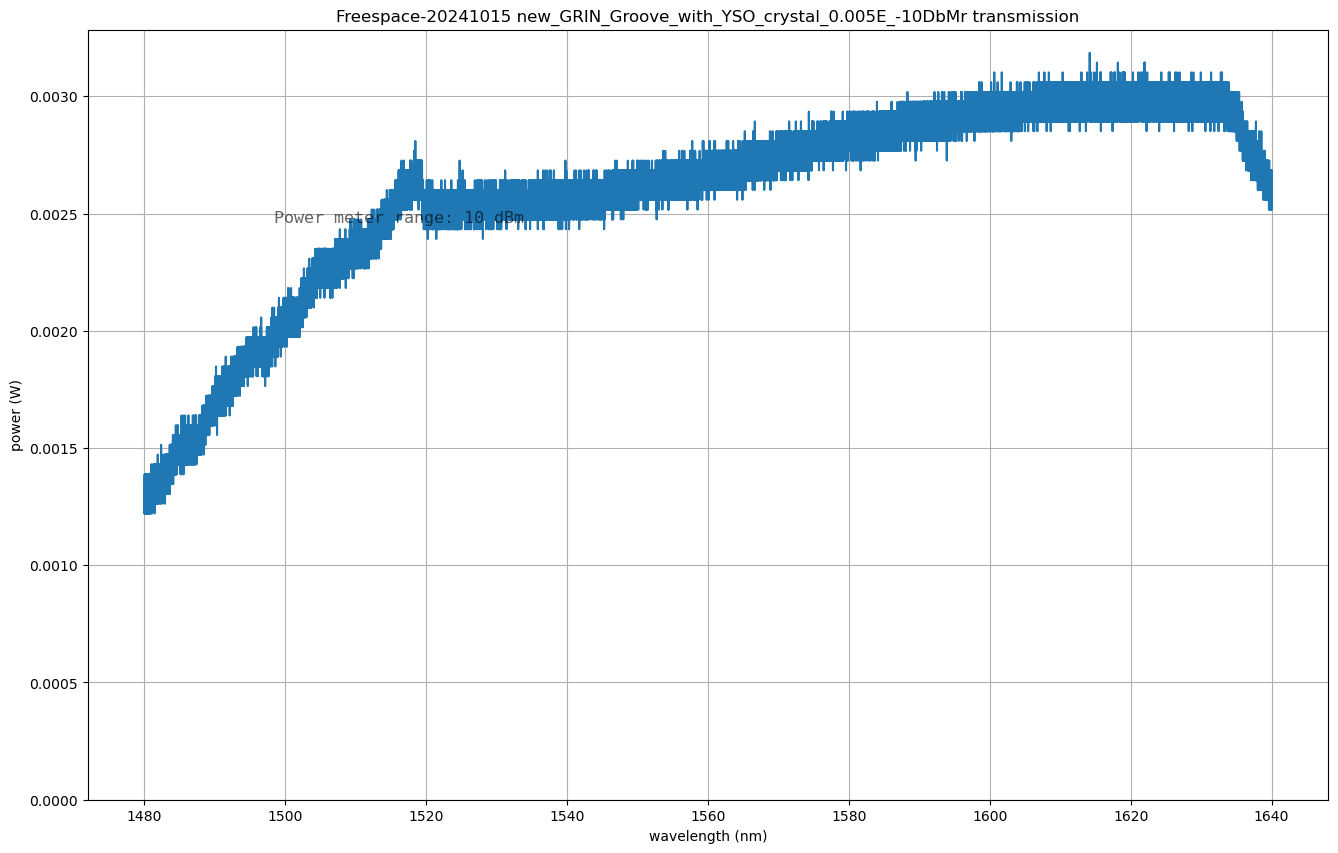

In [20]:
plt.close()
plt.figure(figsize=(16, 10))
plt.plot(wav_arr, data_arr_cut * 10 ** (PM_RANGE / 10) * 1e-3)
plt.grid()
plt.xlabel("wavelength (nm)")
plt.ylabel("power (W)")
plt.ylim(0, None)
# plt.title(f'ESO reflection 1500-1600nm, faster sweep speed')
plt.title(f"{chip_name} transmission")
plt.annotate(
    f"Power meter range: {PM_RANGE} dBm",
    (0.15, 0.75),
    xycoords="axes fraction",
    alpha=0.6,
    fontsize=12,
    fontfamily="monospace",
)
plt.show()

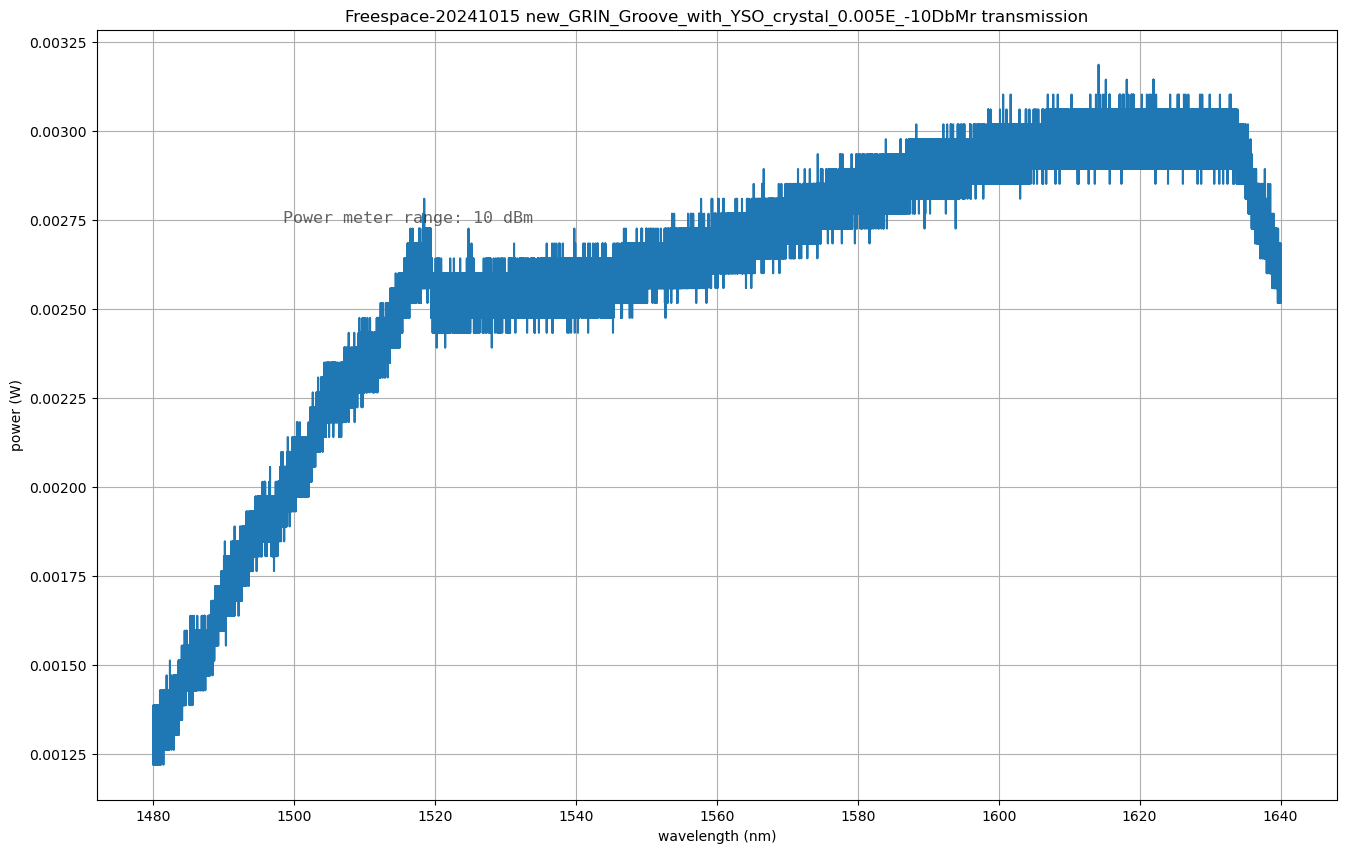

In [21]:
plt.close()
plt.figure(figsize=(16, 10))
plt.plot(wav_arr, data_arr_cut * 10 ** (PM_RANGE / 10) * 1e-3)
plt.grid()
plt.xlabel("wavelength (nm)")
plt.ylabel("power (W)")
# plt.title(f'ESO reflection 1500-1600nm, faster sweep speed')
plt.title(f"{chip_name} transmission")
plt.annotate(
    f"Power meter range: {PM_RANGE} dBm",
    (0.15, 0.75),
    xycoords="axes fraction",
    alpha=0.6,
    fontsize=12,
    fontfamily="monospace",
)
plt.show()

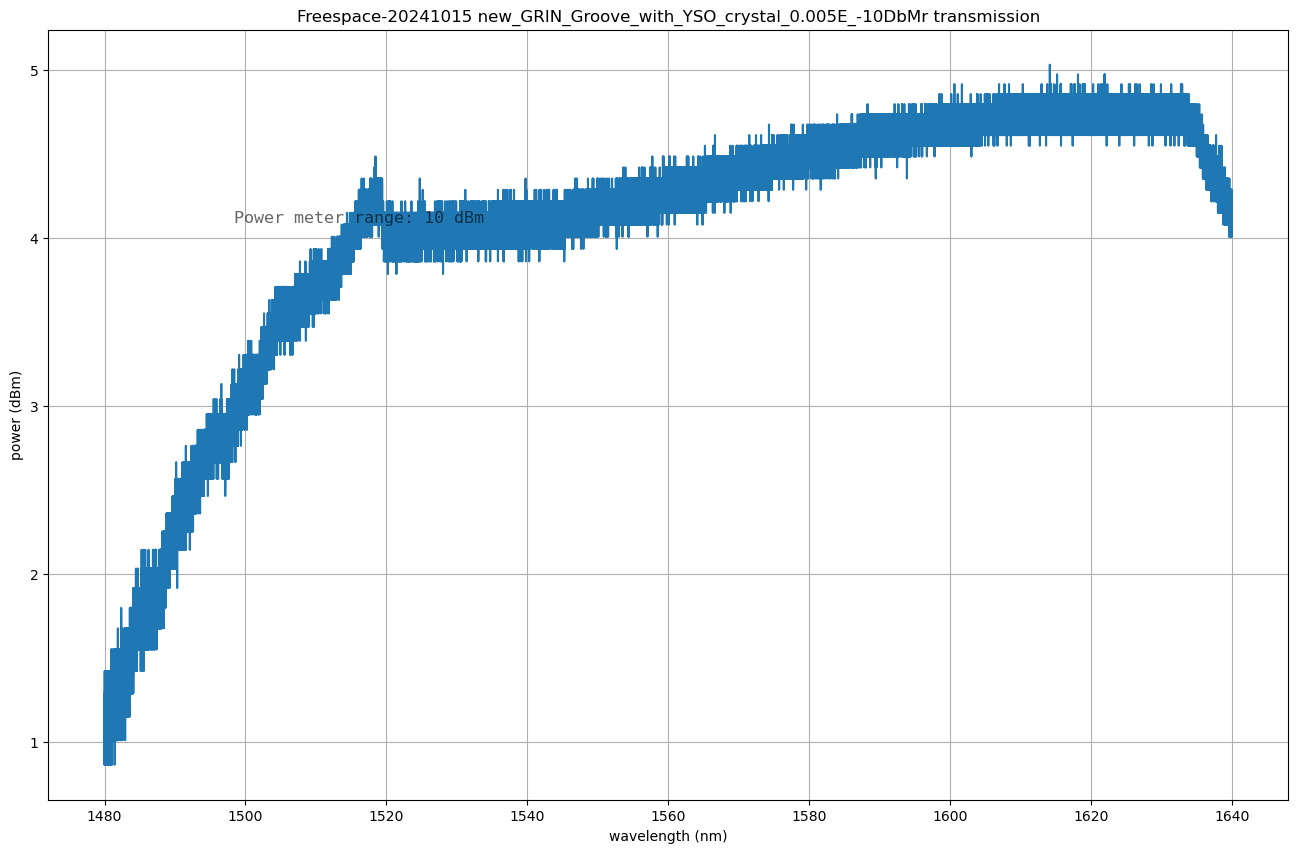

In [22]:
plt.close()
plt.figure(figsize=(16, 10))
watt = list(data_arr_cut * 10 ** (PM_RANGE / 10) * 1e-3)
dBm = list(map(lambda x: math.log10(x) * 10 + 30, watt))
plt.plot(wav_arr, dBm)
plt.grid()
plt.xlabel("wavelength (nm)")
plt.ylabel("power (dBm)")
# plt.title(f'ESO reflection 1500-1600nm, faster sweep speed')
plt.title(f"{chip_name} transmission")
plt.annotate(
    f"Power meter range: {PM_RANGE} dBm",
    (0.15, 0.75),
    xycoords="axes fraction",
    alpha=0.6,
    fontsize=12,
    fontfamily="monospace",
)
plt.show()

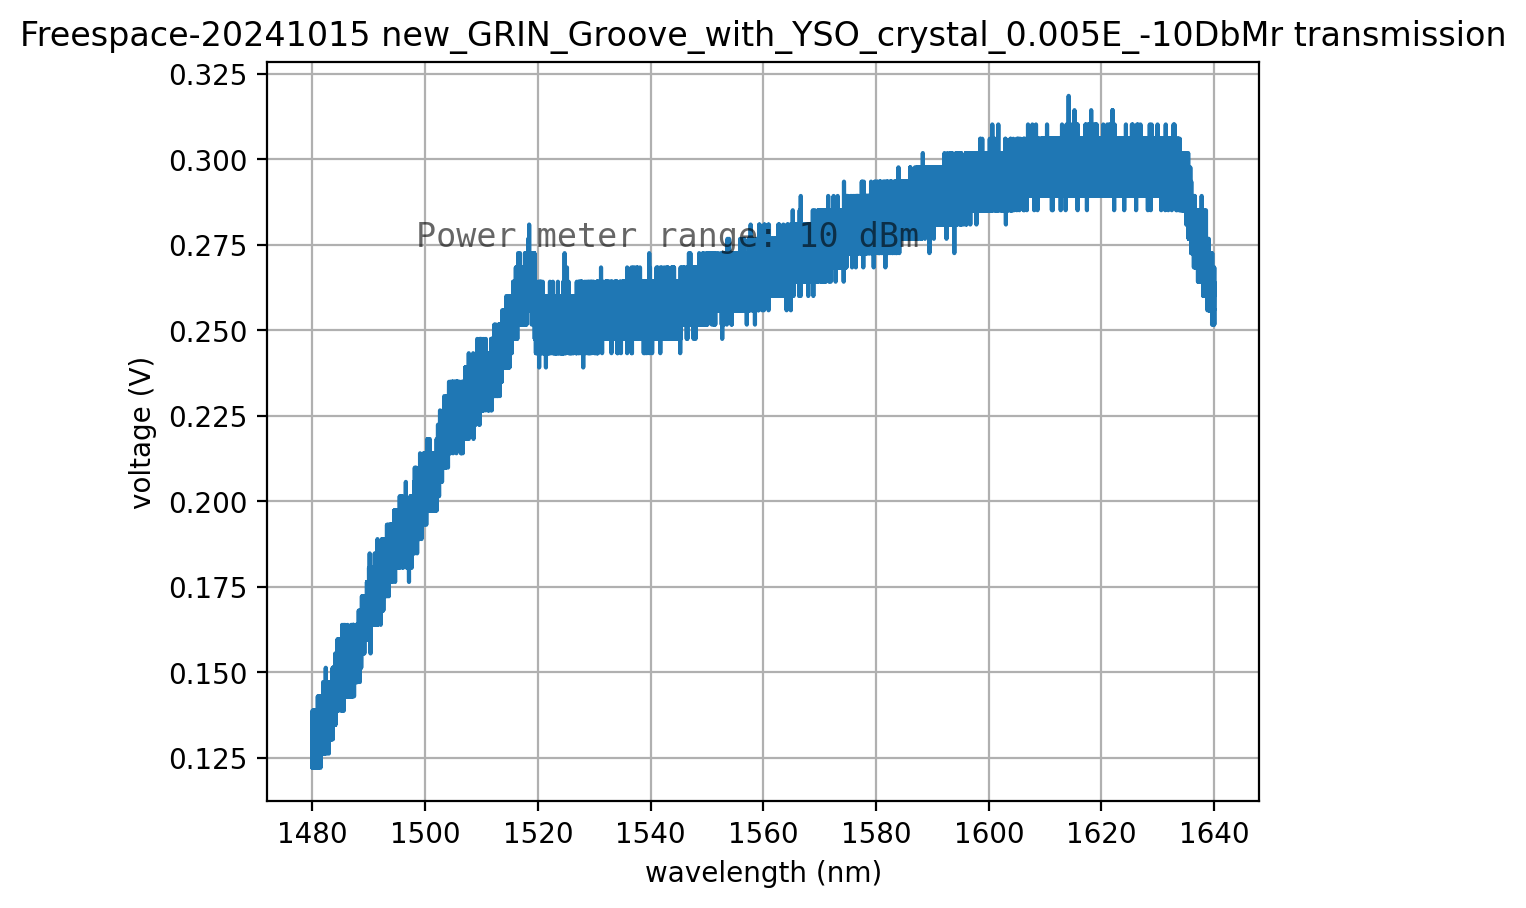

In [23]:
plt.close()
plt.plot(wav_arr, data_arr_cut)
plt.grid()
plt.xlabel("wavelength (nm)")
plt.ylabel("voltage (V)")
plt.title(f"{chip_name} transmission")
plt.annotate(
    f"Power meter range: {PM_RANGE} dBm",
    (0.15, 0.75),
    xycoords="axes fraction",
    alpha=0.6,
    fontsize=12,
    fontfamily="monospace",
)
plt.gcf().set_dpi(200)
plt.show()

In [24]:
# np.savez(f'20240606_ESO_Reflection_50nms.npz', time_arr=time_arr, data_arr=data_arr, clock_arr=clock_arr, wav_arr=wav_arr, time_arr_cut=time_arr_cut, data_arr_cut=data_arr_cut, chip_name=chip_name, PM_RANGE=PM_RANGE)
np.savez(
    f"{CHIP_ID}_{FEATURE_ID}.npz",
    time_arr=time_arr,
    data_arr=data_arr,
    clock_arr=clock_arr,
    wav_arr=wav_arr,
    time_arr_cut=time_arr_cut,
    data_arr_cut=data_arr_cut,
    chip_name=chip_name,
    PM_RANGE=PM_RANGE,
)

In [25]:
TSL.write("WAV:SWE 0")

11

In [26]:
TSL.write("WAV 1520nm")

12

In [27]:
# if TSL.query(":POW:STAT?") == "+1":
#     TSL.write(":POW:STAT 0") # Turn off laser
TSL.close()
DSO.close()
del TSL
del DSO